# Charge transfer

Let us study the ethylene dimer as a simple and concrete example of the issue with charge-transfer (CT) excitations in TDDFT. We first create an *xyz*-file for an H-aggregate stacked along the *z*-axis with an easy way to alter the intermolecular separation distance. 

In [1]:
dimer_xyz = """12

C        0.67759997    0.00000000    -zcoord
C       -0.67759997    0.00000000    -zcoord
H        1.21655197    0.92414474    -zcoord
H        1.21655197   -0.92414474    -zcoord
H       -1.21655197   -0.92414474    -zcoord
H       -1.21655197    0.92414474    -zcoord
C        0.67759997    0.00000000     zcoord
C       -0.67759997    0.00000000     zcoord
H        1.21655197    0.92414474     zcoord
H        1.21655197   -0.92414474     zcoord
H       -1.21655197   -0.92414474     zcoord
H       -1.21655197    0.92414474     zcoord"""

In [2]:
import py3Dmol

viewer = py3Dmol.view(width=400, height=300)

viewer.addModel(dimer_xyz.replace("zcoord", "2.0"))
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})

# rotate for a better initial view
viewer.rotate(-90, "x")

viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

This system is also found in the section on  [selection rules](sec:selection_rules), where the Frenkel excitonic states, $| \sigma \rangle$ and $| \gamma \rangle$, and the charge-transfer states, $| \delta \rangle$ and $| \rho \rangle$, were introduced. They are illustrated in the figure below together with the canonical and delocalized molecular orbitals (MOs) that are involved in the associated electronic excitation processes. 

![H-aggregate](../../img/spec_prop/h-aggregate.png) 

The nature of the excited states is revealed by plotting the excitation energies as a function of dimer separation distance, see figure below. The excitation energies for the excitonic states are only weakly dependent on the distance whereas those of the CT states show a strong dependence.

Moreover, it is seen that the excitation energies of the CT (but not excitonic) states strongly depend on the amount of exact Hartree–Fock (HF) exchange in the exchange–correlation (XC) functional. We are here adopting the B3LYP and BHANDHLYP functionals with some 20% and 50% of HF exchange, respectively.

The excitation energies of the CT states are severely underestimated and unrealistic at the B3LYP level of theory. 

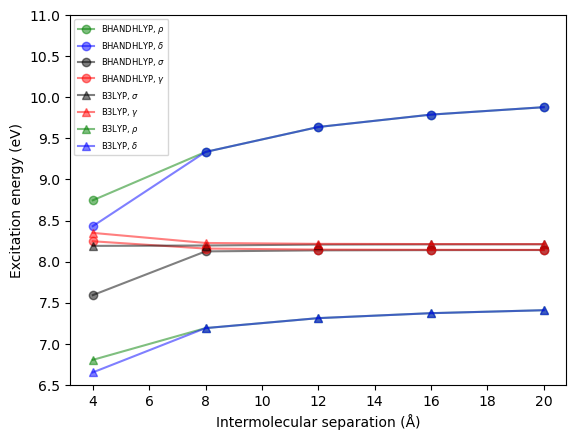

In [3]:
import matplotlib.pyplot as plt
import numpy as np

d = 2 * np.arange(2.0, 11.0, 2.0)

plt.plot(
    d,
    [8.7460, 9.3348, 9.6384, 9.7892, 9.8796],
    "o-",
    alpha=0.5,
    color="green",
    label=r"BHANDHLYP, $\rho$",
)
plt.plot(
    d,
    [8.4311, 9.3348, 9.6384, 9.7892, 9.8796],
    "o-",
    alpha=0.5,
    color="blue",
    label=r"BHANDHLYP, $\delta$",
)
plt.plot(
    d,
    [7.5915, 8.1239, 8.1364, 8.1393, 8.1403],
    "o-",
    alpha=0.5,
    color="black",
    label=r"BHANDHLYP, $\sigma$",
)
plt.plot(
    d,
    [8.2471, 8.1582, 8.1462, 8.1434, 8.1424],
    "o-",
    alpha=0.5,
    color="red",
    label=r"BHANDHLYP, $\gamma$",
)

plt.plot(
    d,
    [8.1910, 8.1955, 8.2069, 8.2095, 8.2104],
    "^-",
    alpha=0.5,
    color="black",
    label=r"B3LYP, $\sigma$",
)
plt.plot(
    d,
    [8.3491, 8.2266, 8.2157, 8.2132, 8.2123],
    "^-",
    alpha=0.5,
    color="red",
    label=r"B3LYP, $\gamma$",
)
plt.plot(
    d,
    [6.8032, 7.1899, 7.3113, 7.3716, 7.4077],
    "^-",
    alpha=0.5,
    color="green",
    label=r"B3LYP, $\rho$",
)
plt.plot(
    d,
    [6.6507, 7.1899, 7.3113, 7.3716, 7.4077],
    "^-",
    color="blue",
    alpha=0.5,
    label=r"B3LYP, $\delta$",
)

plt.legend(fontsize=6)

plt.xlabel("Intermolecular separation (Å)")
plt.ylabel("Excitation energy (eV)")

plt.setp(plt.gca(), ylim=[6.5, 11])

plt.show()

The underlying data for the figure above has been calculated with use of the VeloxChem program and the code cells found below. You can create all data by activating the iterations over distances and functionals in the code cell.

Here we will run the calculation for a single dimer separation of 20 Å and use the well-behaved BHANDHLYP functional.

In [4]:
import veloxchem as vlx

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


In [5]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()

lreig_drv = vlx.LinearResponseEigenSolver()
lreig_drv.ostream.mute()
lreig_drv.nstates = 6

In [6]:
# for xcfun in ["b3lyp", "bhandhlyp"]:
for xcfun in ["bhandhlyp"]:
    print(f"XC functional: {xcfun:16s}")
    scf_drv.xcfun = xcfun

    # for zcoord in np.arange(2.0, 11.0, 2.0):
    for zcoord in np.arange(10.0, 11.0, 2.0):
        print(f"Z coordinate: {zcoord:8.2f}")

        molecule = vlx.Molecule.read_xyz_string(
            dimer_xyz.replace("zcoord", str(zcoord))
        )
        basis = vlx.MolecularBasis.read(molecule, "6-31g", ostream=None)

        scf_results = scf_drv.compute(molecule, basis)

#        lreig_drv.detach_attach = True
#        lreig_drv.filename = "dimer_20A"

        lreig_results = lreig_drv.compute(molecule, basis, scf_results)

        print(
            f"   {'E (eV)':8s}{'mu_x':8s}{'mu_y':8s}{'mu_z':8s}{'m_x':8s}{'m_y':8s}{'m_z':8s}{'f':8s}{'R':8s}"
        )
        print(72 * "-")

        for E, e, m, f, R in zip(
            lreig_results["eigenvalues"],
            lreig_results["electric_transition_dipoles"],
            lreig_results["magnetic_transition_dipoles"],
            lreig_results["oscillator_strengths"],
            lreig_results["rotatory_strengths"],
        ):
            print(
                f"{E*27.2114:8.4f}{e[0]:8.4f}{e[1]:8.4f}{e[2]:8.4f}{m[0]:8.4f}{m[1]:8.4f}{m[2]:8.4f}{f:8.4f}{R:8.4f}"
            )

XC functional: bhandhlyp       
Z coordinate:    10.00
   E (eV)  mu_x    mu_y    mu_z    m_x     m_y     m_z     f       R       
------------------------------------------------------------------------
  8.1403  0.0000 -0.0000  0.0000  0.0000 -4.9598  0.0000  0.0000  0.0000
  8.1424  2.0065  0.0000 -0.0000 -0.0000  0.0000 -0.0000  0.8031 -0.0000
  9.5360 -0.0000  0.0000  0.0214 -0.0000  0.0000  0.0000  0.0001  0.0000
  9.5360 -0.0000 -0.0000 -0.0015  0.0000 -0.0000 -0.0000  0.0000  0.0000
  9.8796  0.0000  0.0000  0.0000 -0.0000 -0.0000  0.0000  0.0000 -0.0000
  9.8796  0.0000 -0.0000  0.0000 -0.0000 -0.0000  0.0000  0.0000 -0.0000


With data restricted to a single molecular configuration and functional, it can be less than obvious to determine the character of electronic transitions. 

It is a common practice to turn to the dominant elements in the excitation vectors. 

In [7]:
for state, exc_str in enumerate(lreig_results['excitation_details']):
    print("State:", state + 1)
    for orb_str in exc_str:
        print(orb_str)

State: 1
HOMO     -> LUMO        -0.5111
HOMO-1   -> LUMO+1       0.5111
HOMO-1   -> LUMO        -0.4831
HOMO     -> LUMO+1      -0.4831
State: 2
HOMO     -> LUMO+1       0.6279
HOMO-1   -> LUMO        -0.6279
HOMO-1   -> LUMO+1      -0.3167
HOMO     -> LUMO        -0.3167
State: 3
HOMO     -> LUMO+2      -0.6216
HOMO-1   -> LUMO+3       0.5475
HOMO-1   -> LUMO+2       0.4217
HOMO     -> LUMO+3       0.3605
State: 4
HOMO-1   -> LUMO+3      -0.5819
HOMO     -> LUMO+2      -0.5020
HOMO     -> LUMO+3      -0.4750
HOMO-1   -> LUMO+2       0.4215
State: 5
HOMO-1   -> LUMO+1      -0.7953
HOMO     -> LUMO+1      -0.5770
State: 6
HOMO     -> LUMO         0.7804
HOMO-1   -> LUMO        -0.5970


At this separation distance, excited states number 1, 2, 5, and 6 are all formed from $\pi\pi^*$-excitations, and from these coefficients alone, the character of the electronic transitions is not clear.

The next level of analysis is reached by turning to the natural transition orbitals (NTOs) or detachment/attachment densities. Below we will use the Valet module to perform a subgroup division of the dimer system into monomers and give a visual presentation of the electronic transitions based on the detachment/attachment densities.

States 5 and 6 amply reveal their CT character in the figure illustrations.

In [8]:
from valet import transition_analysis_utils as tau

In [9]:
subgroup_name = ["Ethylene 1", "Ethylene 2"]
atom_subgroup_map = [0] * 6 + [1] * 6
print(atom_subgroup_map)

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


In [10]:
def plot_transition_diagram(state_index, filename, subgroup_name, atom_subgroup_map):
    folder = "../../data/tddft/" # Path to where the cube files were saved

    density_type_plus = "detach"  # or hole
    density_type_minus = "attach"  # or electron/particle

    hole_cube = "%s_S%d_%s.cube" % (folder + filename, state_index, density_type_plus)
    particle_cube = "%s_S%d_%s.cube" % (
        folder + filename,
        state_index,
        density_type_minus,
    )

    # We have to load the detachment and attachment densities and compute the atomic charges
    transition = tau.load_transition(hole_cube, particle_cube)
    segment_array = tau.compute_atomic_charges([transition])

    subgroup_info = tau.SubgroupInfo()

    # Determine subgroup charges
    subgroup_info.set_subgroups(subgroup_name, atom_subgroup_map)
    tau.compute_subgroup_charges(transition, subgroup_info)

    diagram_title = "Ethylene dimer: State %d" % (state_index)

    tau.create_diagram(subgroup_info, title=diagram_title, save_plot=False)

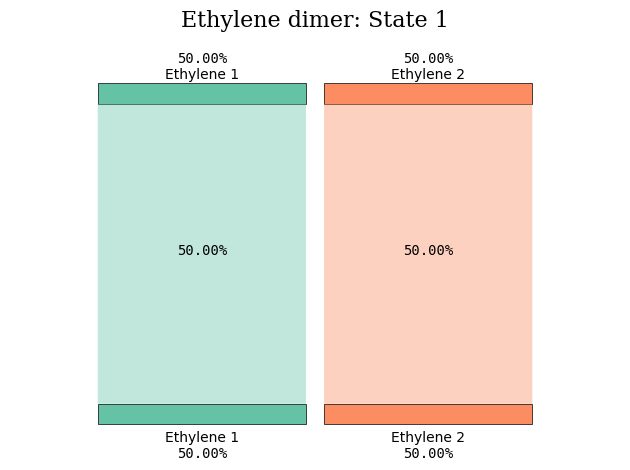

In [11]:
plot_transition_diagram(1, "dimer_20A", subgroup_name, atom_subgroup_map)

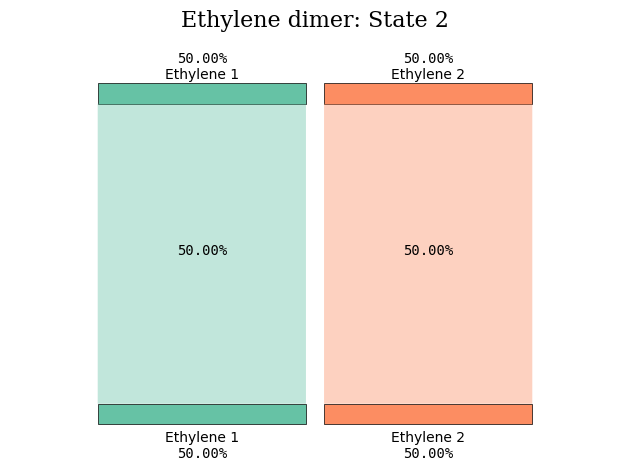

In [12]:
plot_transition_diagram(2, "dimer_20A", subgroup_name, atom_subgroup_map)

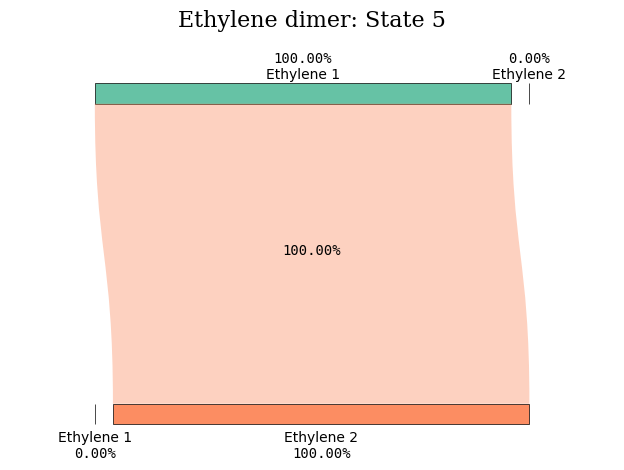

In [13]:
plot_transition_diagram(5, "dimer_20A", subgroup_name, atom_subgroup_map)

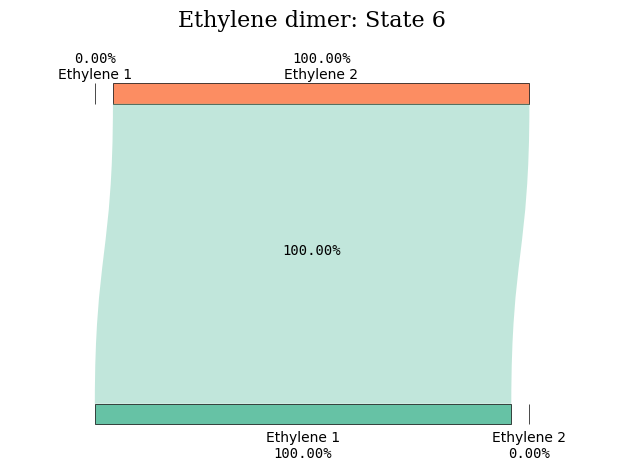

In [15]:
plot_transition_diagram(6, "dimer_20A", subgroup_name, atom_subgroup_map)